In [10]:
# Visual comparison of estimator distributions in beta space for d=2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Ellipse

np.random.seed(3)

# dimensions
n = 100   # number of observations
d = 2   # dimension of data

# design matrix (must be full column rank - random data will almost surely be)
Z = np.random.randn(n, d)

# the true parameters
beta_true = np.array([0, 0]).reshape(d, 1) # need to estimate
sigma_2 = 0.5 # known

# OLS estimator matrix - should minimize variance
A_LS = np.linalg.inv(Z.T @ Z) @ Z.T

# Construct another unbiased estimator A = A_LS + C with C Z = 0
P_Z = Z @ np.linalg.inv(Z.T @ Z) @ Z.T # projection matrix onto the column space of Z

# I-P_Z acts on the random noise orthogonal to the column space of Z.
# This is what A_LS intentionally ignores, since it can't possibly be part of the true signal.
C = 0.01 * np.random.randn(d, n) @ (np.eye(n) - P_Z) 
A = A_LS + C

# Monte Carlo sample clouds - sample Y many times and get the 2 estimators for each sample
n_mc = 100000
epsilon = np.random.normal(0, np.sqrt(sigma_2), (n, n_mc))
Ys = (Z @ beta_true + epsilon)  # (n, n_mc)
ests_ls = A_LS @ Ys  # (d, n_mc) - each column is the estimate for a different Monte Carlo sample
ests_A = A @ Ys      # (d, n_mc)

# compute the theoretical variances
var_ls = sigma_2 * A_LS @ A_LS.T
var_A = sigma_2 * A @ A.T

# Compute the empirical variance from the sampled data
var_ls_emp = np.cov(ests_ls)
var_A_emp = np.cov(ests_A)

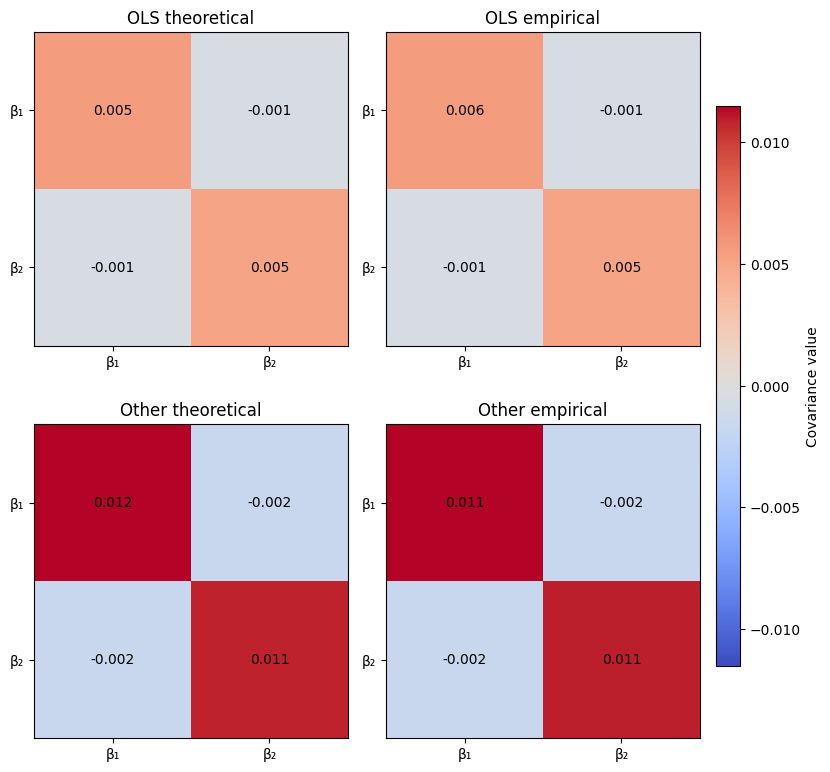

In [11]:

# Variance matrix comparison: theoretical vs empirical, OLS vs Other (heatmaps)
labels = [
    ("OLS theoretical", var_ls),
    ("OLS empirical", var_ls_emp),
    ("Other theoretical", var_A),
    ("Other empirical", var_A_emp),
]

# common color scale centered at 0 across all matrices
global_max = max(float(np.max(np.abs(m))) for _, m in labels)
norm = TwoSlopeNorm(vmin=-global_max, vcenter=0.0, vmax=global_max)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, (title, M) in zip(axes.ravel(), labels):
    im = ax.imshow(M, cmap="coolwarm", norm=norm)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["β₁", "β₂"])
    ax.set_yticklabels(["β₁", "β₂"])
    # annotate values
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(j, i, f"{M[i, j]:.3f}", va="center", ha="center", color="black")

# reserve space on the right for a single shared colorbar
plt.tight_layout(rect=[0, 0, 0.88, 1])
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cax, label="Covariance value")
plt.show()

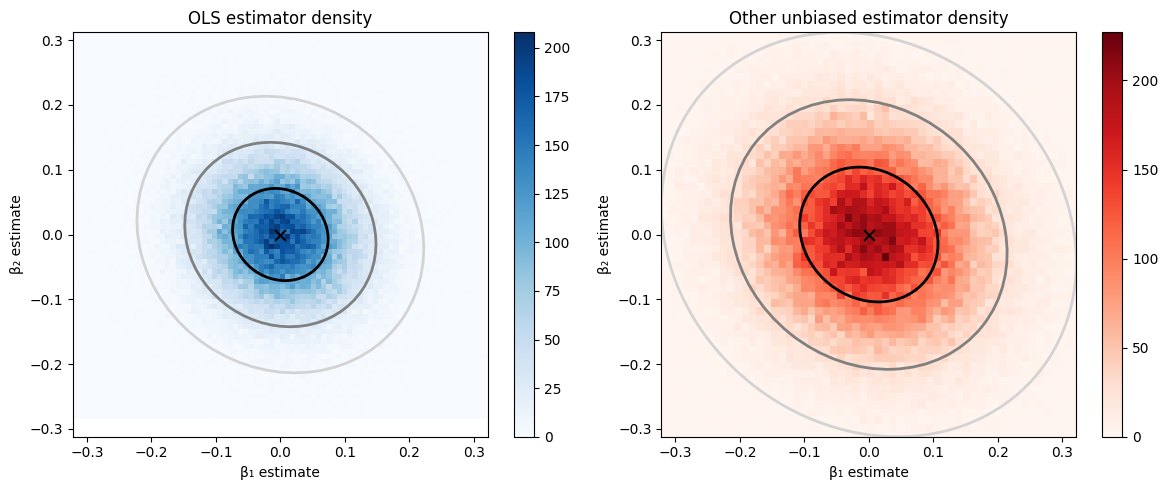

In [12]:

# Heatmap visualization using 2D histogram (density estimate) for each estimator around the true beta
bins = 80 

x_min = beta_true[0,0] - 3 * np.sqrt(var_A[0,0]) 
x_max = beta_true[0,0] + 3 * np.sqrt(var_A[0,0]) 
y_min = beta_true[1,0] - 3 * np.sqrt(var_A[1,1]) 
y_max = beta_true[1,0] + 3 * np.sqrt(var_A[1,1])

def plot_cov_ellipse(cov, mean, ax, nstd=1, **kwargs):
    """Plot an nstd covariance ellipse on ax."""
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    # sqrt of eigenvalues * nstd gives radii
    width, height = 2 * nstd * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# OLS estimator
h1 = axs[0].hist2d(ests_ls[0,:], ests_ls[1,:], bins=bins, cmap="Blues")
axs[0].scatter([beta_true[0,0]], [beta_true[1,0]], c="black", s=60, marker="x")
axs[0].set_title("OLS estimator density")
axs[0].set_xlabel("β₁ estimate")
axs[0].set_ylabel("β₂ estimate")
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
plt.colorbar(h1[3], ax=axs[0])

for k, c in zip([1, 2, 3], ["black", "gray", "lightgray"]):
    plot_cov_ellipse(var_ls, beta_true.ravel(), axs[0], nstd=k, edgecolor=c, facecolor="none", lw=2)

# Other unbiased estimator
h2 = axs[1].hist2d(ests_A[0,:], ests_A[1,:], bins=bins, cmap="Reds")
axs[1].scatter([beta_true[0,0]], [beta_true[1,0]], c="black", s=60, marker="x")
axs[1].set_title("Other unbiased estimator density")
axs[1].set_xlabel("β₁ estimate")
axs[1].set_ylabel("β₂ estimate")
axs[1].set_xlim(x_min, x_max)
axs[1].set_ylim(y_min, y_max)
plt.colorbar(h2[3], ax=axs[1])

for k, c in zip([1, 2, 3], ["black", "gray", "lightgray"]):
    plot_cov_ellipse(var_A, beta_true.ravel(), axs[1], nstd=k, edgecolor=c, facecolor="none", lw=2)

plt.tight_layout()
plt.show()